# **Darooghe Payment Service Provider Analysis**

**Authors:** 
-  *Mahdy Mokhtari 810101515*
-  *Alborz Mahmoudian 810101514*
-  *Niloufar Mortazavi 220701096*

**Quick Project Explanation**

We are 'Darooghe', a **payment service provider** offering payment services via Online Payment
Gateway, POS (Point of Sale) Device, Mobile Application, and NFC (Contactless) Payment.
Our pipeline will process transaction events, calculate commissions, detect fraudulent
activities, and provide business intelligence insights.

This notebook implements a **historical & real‑time** pipeline for Darooghe: ingesting transaction events via Kafka, processing them in batch layers for the historical events and with Spark for the real time events, storing results in MongoDB, and exposing **transaction** and **commission** metrics and **fraud alerts** for BI consumers.

**Core Requirements:** 
1.  Kafka
2.  Spark
3.  MongoDB






## Requirments Explanation

### Kafka

**Apache Kafka** is an <u>open-source</u> <u>distributed</u> **event-streaming platform** developed by the Apache Software Foundation. 
It is designed to handle high-throughput, low-latency data feeds for **real-time analytics** and monitoring. 


### Apache Spark

**Apache Spark** is an <u>open‑source</u>, <u>distributed analytics engine</u> designed for **large‑scale data processing**. It provides in‑memory computation and a rich set of high‑level APIs in Python, Java, Scala, and R, enabling fast ETL, machine learning, streaming, and graph analytics. Spark’s resilient distributed datasets (RDDs) and DataFrame abstractions make it easy to build complex workflows that scale across clusters with fault tolerance and high throughput.  


**PySpark** is the Python API for Apache Spark, a powerful
open-source framework designed for large-scale data processing
and analytics. It enables users to leverage Spark's distributed computing capabilities using
Python, facilitating tasks such as data transformation, machine learning, and real-time
stream processing.


### MongoDB

**MongoDB** is a <u>NoSQL</u> database that organizes data into <u>collections</u> of **JSON‑like documents**, so you don’t need a fixed schema up front. This makes it super flexible—you can add or change fields on the fly. It also includes built‑in replication for high availability and sharding to spread data across servers as you grow.  


## **Enviromant Setup** 

In this part we will do all the downloading and installing so our system will have the proper tools for this project.

We have a **darooghe_pulse.py** code that should get executed and dont stop. It will act as our fake self-produce transactions with a self made configuration which I have brought here so we could see. This file is being executed somewhere else so the process could continue and that code works as an **External transaction producer**.

**NOTE : This part would not be part of the project if we had real transactions of a payment service provider.**

### Configuration Parameters

To control the transaction generator and simulation, you can tweak the following settings:

| Parameter       | Description                       | Default | Valid Range |
|-----------------|-----------------------------------|:-------:|-------------|
| **EVENT_RATE**      | Average events per minute         |   100   | 10–1,000    |
| **PEAK_FACTOR**     | Multiplier for peak‐hour traffic  |   2.5   | 1.0–5.0     |
| **FRAUD_RATE**      | Fraction of transactions flagged as fraud |  0.02   | 0.0–0.10   |
| **DECLINED_RATE**   | Fraction of transactions declined    |  0.05   | 0.0–0.20   |
| **MERCHANT_COUNT**  | Number of unique merchants           |    50   | 10–500      |
| **CUSTOMER_COUNT**  | Number of unique customers           |  1,000  | 100–10,000  |

The generator follows a _non‑homogeneous Poisson process_ to simulate daily and weekly volume patterns.

---

### Transaction Data Schema

All events conform to the following schema before processing or storage:

| Field               | Type       | Description                                                         |
|-------------------- |----------- |-------------------------------------------------------------------- |
| **transaction_id**    | `String`   | UUID for each transaction                                          |
| **timestamp**         | `Timestamp`| ISO‑8601 time of transaction                                       |
| **customer_id**       | `String`   | Identifier of the paying customer                                  |
| **merchant_id**       | `String`   | Identifier of the receiving merchant                               |
| **merchant_category** | `String`   | One of `retail`, `food_service`, `entertainment`, `transportation`, `government` |
| **payment_method**    | `String`   | One of `online`, `pos`, `mobile`, `nfc`                            |
| **amount**            | `Double`   | Base transaction amount (IRR)                                       |
| **vat_amount**        | `Double`   | Value‐added tax applied                                             |
| **commission_type**   | `String`   | One of `flat`, `progressive`, `tiered`                             |
| **commission_amount** | `Double`   | Fee collected by Darooghe (IRR)                                     |
| **total_amount**      | `Double`   | `amount + vat_amount + commission_amount`                           |
| **status**            | `String`   | One of `approved`, `declined`, `pending`                           |
| **location**          | `Struct`   | `{ lat: Double, lng: Double }`                                      |
| **device_info**       | `Struct`   | `{ os: String, app_version: String, device_model: String }`         |
| **customer_type**     | `String`   | One of `individual`, `CIP`, `business`                             |
| **risk_level**        | `Integer`  | Risk score assigned (1–5)                                           |
| **failure_reason**    | `String`   | One of `cancelled`, `insufficient_funds`, `system_error`, `fraud_prevented`, or `null` |

This schema drives validation, storage (MongoDB collections) and downstream Spark processing.  



## **Data Ingestion Layer**

**Data ingestion** is the process of collecting data from sources into one single centralized system for analysis.

In [1]:
import os
import json
import logging
from confluent_kafka import Consumer, Producer
from datetime import datetime
from typing import Dict

Writing the **Transction** class to be like a **data structure** which also contains some **validation functions** which we have to check and make sure the transaction data is correct.

I included the appropriate **type conversions** in the **constructor** of the class.

In [2]:
class Transaction:
    def __init__(self, data: dict):  
        self.transaction_id = str(data.get("transaction_id"))
        self.timestamp = str(data.get("timestamp"))
        self.customer_id = str(data.get("customer_id"))
        self.merchant_id = str(data.get("merchant_id"))
        self.merchant_category = str(data.get("merchant_category"))
        self.payment_method = str(data.get("payment_method"))
        self.amount = int(data.get("amount"))
        self.location = dict(data.get("location", {}))
        self.device_info = dict(data.get("device_info", {}))
        self.status = str(data.get("status"))
        self.commission_type = str(data.get("commission_type"))
        self.commission_amount = int(data.get("commission_amount"))
        self.vat_amount = int(data.get("vat_amount"))
        self.total_amount = int(data.get("total_amount"))
        self.customer_type = str(data.get("customer_type"))
        self.risk_level = int(data.get("risk_level"))
        self.failure_reason = data.get("failure_reason")

        self.valid_bool = True

    ##### Rule 1 - Amount Consistency
    def validate_amount_consistency(self, producer: Producer, transaction_data: Dict):
        if self.total_amount != self.amount + self.vat_amount:
            self.valid_bool = False
            error_payload = {
                "transaction_id": self.transaction_id,
                "error_code": "ERR_AMOUNT",
                "error_message": "Total amount mismatch",
                "original_data": transaction_data
            }
            producer.produce("darooghe.error_logs", key=self.transaction_id, value=json.dumps(error_payload))
            print("Rule 1")
            raise ValueError("ERR_AMOUNT: Total amount mismatch")


    ##### Rule 2 - Time Warping
    def validate_time_warping(self, producer: Producer, transaction_data: Dict):
        try:
            event_time = datetime.strptime(self.timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
        except Exception as e:
            self.valid_bool = False
            error_payload = {
                "transaction_id": self.transaction_id,
                "error_code": "ERR_TIME",
                "error_message": f"Timestamp parse error: {e}",
                "original_data": transaction_data
            }
            producer.produce("darooghe.error_logs", key=self.transaction_id, value=json.dumps(error_payload))
            print("Rule 2")
            raise ValueError(f"ERR_TIME: Timestamp parse error")

        now = datetime.utcnow()
        if event_time > now or (now - event_time).total_seconds() > 86400:
            self.valid_bool = False
            error_payload = {
                "transaction_id": self.transaction_id,
                "error_code": "ERR_TIME",
                "error_message": "Timestamp is either from the future or too old",
                "original_data": transaction_data
            }
            producer.produce("darooghe.error_logs", key=self.transaction_id, value=json.dumps(error_payload))
            print("Rule 2")
            raise ValueError("ERR_TIME: Timestamp out of valid range")


    ##### Rule 3 - Device Mismatch
    def validate_device_mismatch(self, producer: Producer, transaction_data: Dict):
        if self.payment_method.lower() == "mobile":
            os_name = self.device_info.get("os", "").lower()
            if os_name not in ["ios", "android"]:
                self.valid_bool = False
                error_payload = {
                    "transaction_id": self.transaction_id,
                    "error_code": "ERR_DEVICE",
                    "error_message": "Unexpected device OS for mobile payment",
                    "original_data": transaction_data
                }
                producer.produce("darooghe.error_logs", key=self.transaction_id, value=json.dumps(error_payload))
                print("Rule 3")
                raise ValueError("ERR_DEVICE: Invalid device OS for mobile payment")


**Configuring** some variables of:

- kafka server

- logging library

- directory and file paths

In [3]:
# ====================  STARTUP  ======================

# Logging configuration
log_level_str = os.getenv("LOG_LEVEL", "INFO").upper()
logging.basicConfig(
    level=getattr(logging, log_level_str, logging.INFO),
    format="%(asctime)s %(levelname)s %(message)s",
)

# Kafka configuration
default_broker = os.getenv("KAFKA_BROKER", "localhost:9092")
kafka_broker = default_broker
topic = "darooghe.transactions"
error_topic = "darooghe.error_logs"
group_id = "darooghe-consumer-group"

conf = {
    "bootstrap.servers": kafka_broker,
    "group.id": group_id,
    "auto.offset.reset": "earliest",
    "enable.auto.commit": True
}

# JSON output configuration
OUTPUT_DIR = "./data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PATH = os.path.join(OUTPUT_DIR, "transactions.json")

#### Kafka Consumer

##### What we did?

We have implemented a kafka consumer using the library "conlfuent_kafka" and its Consumer class.

It first connects to the **kafka server** on <b>port 9092</b> on our our machine which is the **local host** (127.0.0.1:9092).

After connecting to the kafka server it reads data from kafkas <b>"darooghe.transactions" topic</b>.

We ananlyze each transaction data if it isnt valid according to our criteria(conditions) then we will write the error log to the kafkas **"darooghe.error_logs" topic**.

If the transaction was valid and passed the validation functions(exams), We will write the first transaction message.

At the end we will close the consumer.

NOTE: ALL THE READING FROM AND WRITING INTO THE TOPICS OF KAFKAS SERVER WHERE HANDELED BY THE "confluenet_kafka" LIBRARY 

##### What is an error here? (What transactions are called invalid?)

| Rule                | Validation Logic                                                  | Error Code  | Insight Potential                              |
|---------------------|-------------------------------------------------------------------|-------------|------------------------------------------------|
| **Amount Consistency** | `total_amount == amount + vat_amount`         | ERR_AMOUNT | Detects misconfigured merchant pricing engines |
| **Time Warping**       | `timestamp not in future AND not more than a day older than Kafka ingestion time` | ERR_TIME   | Surfaces clock drift in POS devices (completely possible!) |
| **Device Mismatch**    | `if (payment_method=="mobile") => device_info.os ∈ ["iOS","Android"]` | ERR_DEVICE | Reveals potentially spoofed device headers     |



NOTE: THE **FIRST RULE** WAS **INCONSISTENT** BETWEEN THE **PYTHON FILE** AND THE **PROJECT DOCUMENTATION**, SO I MADE A PRE-ASSUMPTION THAT THE CODE WAS CORRECT AND REWROTE THE DOCUMENT RULE TABLE (THE UPDATED VERSION IS HERE AT THE TOP OF THIS NOTE).


In [4]:
# ===============================  Run Consumer  ============================

consumer = Consumer(conf)
consumer.subscribe([topic])
producer = Producer({"bootstrap.servers": kafka_broker})

print("Consumer is now listening to topic:", topic)

try:
    while True:
        msg = consumer.poll(1.0)

        if msg is None:
            print("wait(Mehdy)..", flush=True)
            continue
        if msg.error():
            logging.error(f"Consumer error: {msg.error()}")
            continue
        
        print("Read raw data")
        raw_data = msg.value().decode("utf-8")
        transaction_data = json.loads(raw_data)

        try:
            transaction = Transaction(transaction_data)

            # validations
            transaction.validate_amount_consistency(producer, transaction_data)
            transaction.validate_time_warping(producer, transaction_data)
            transaction.validate_device_mismatch(producer, transaction_data)
            producer.flush()

            # If we reach here, no schema error was raised.
            # writing the transaction to json file
            print("Valid Transaction Object:")
            print(vars(transaction))
            with open(OUTPUT_PATH, "a") as outfile:
                json.dump(transaction.__dict__, outfile)
                outfile.write("\n")
            break
            

        except ValueError as ve:
            # error already sent
            print("value error")
            producer.flush()
            continue

        except Exception as e:
            # Schema or instantiation error
            error_payload = {
                "transaction_id": transaction_data.get("transaction_id"),
                "error_code": "ERR_SCHEMA",
                "error_message": str(e),
                "original_data": transaction_data
            }
            producer.produce(
                error_topic,
                key=transaction_data.get("transaction_id"),
                value=json.dumps(error_payload)
            )
            print("exception error")
            print(str(e))
            producer.flush()
            continue

finally:
    consumer.close()


Consumer is now listening to topic: darooghe.transactions
wait(Mehdy)..
wait(Mehdy)..
wait(Mehdy)..
wait(Mehdy)..
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Rule 2
value error
Read raw data
Valid Transaction Object:
{'transaction_id': '2065fe85-29c0-4f49-bfad-e4e61dd2210f', 'timestamp': '2025-04-23T02:35:26.418165Z', 'customer_id': 'cust_261', 'merchant_id': 'merch_22', 'merchant_category': 'government', 'payment_method': 'pos', 'amount': 1529230, 'location': {'lat': 35.705017442785206, 'lng': 51.28685438217433}, 'device_info': {}, 'status': 'approved', 'commission_type': 'tiered', 'commission_amount': 30584, 'vat_amount': 13

## **Batch Processing Layer**

This task focuses on analyzing **existing transactional data** that has already been collected and stored. Using **PySpark**, the goal is to extract meaningful patterns, summaries, and insights from the historical dataset for further interpretation and visualization.

### Commission Analysis Batch Job

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, col, when

##### Total commission per merchant_category

This aggregation computes the total commission earned from transactions in each merchant category.

Helping identify which categories generate the highest commission revenue.

##### Avg commission per transaction per category

This calculates the average commission per transaction within each merchant category.

Providing insights into typical commission values per sale for different types of businesses.

##### Avg commission-to-transaction ratio

This metric shows the proportion of commission relative to the transaction amount for each category. 

It helps evaluate the efficiency or fairness of commission rates across different merchant types.

In [6]:
spark = SparkSession.builder \
    .appName("CommissionAnalysis") \
    .getOrCreate()

df = spark.read.json("data/transactions.json")

# total commission per merchant_category
total_commission = df.groupBy("merchant_category") \
    .agg(sum("commission_amount").alias("total_commission"))

# avg commission per transaction per category
avg_commission = df.groupBy("merchant_category") \
    .agg(avg("commission_amount").alias("avg_commission"))

# avg commission-to-transaction ratio
agg_df = (
    df
    .groupBy("merchant_category")
    .agg(
        sum("commission_amount").alias("total_commission"),
        sum("amount").alias("total_amount")
    )
)
avg_ratio = (
    agg_df
    .withColumn(
        "commission_to_transaction_ratio",
        col("total_commission") / col("total_amount")
    )
)
avg_ratio = avg_ratio.select(
    "merchant_category",
    "commission_to_transaction_ratio"
)
avg_ratio.show(truncate=False)


report = total_commission \
    .join(avg_commission, on="merchant_category") \
    .join(avg_ratio, on="merchant_category")

# printing real commission report
print("=== Actual Commission Report ===")
report.show(truncate=False)
report.write.mode("overwrite").json("output/CommissionAnalysis/real_commission")

25/04/23 19:38:50 WARN Utils: Your hostname, MahdyBeast resolves to a loopback address: 127.0.1.1, but we couldn't find any external IP address!
25/04/23 19:38:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/23 19:38:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/23 19:39:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----------------+-------------------------------+
|merchant_category|commission_to_transaction_ratio|
+-----------------+-------------------------------+
|retail           |0.01999952397671913            |
|entertainment    |0.019999519521188003           |
|food_service     |0.019999519302522223           |
|government       |0.019999535347876404           |
|transportation   |0.019999518359948242           |
+-----------------+-------------------------------+

=== Actual Commission Report ===


+-----------------+----------------+------------------+-------------------------------+
|merchant_category|total_commission|avg_commission    |commission_to_transaction_ratio|
+-----------------+----------------+------------------+-------------------------------+
|retail           |91843742        |20732.221670428895|0.01999952397671913            |
|entertainment    |93105719        |20462.795384615383|0.019999519521188003           |
|food_service     |93248092        |20368.74006116208 |0.019999519302522223           |
|government       |94060443        |20745.576312307014|0.019999535347876404           |
|transportation   |93330522        |20444.802190580504|0.019999518359948242           |
+-----------------+----------------+------------------+-------------------------------+



Now lets simulate my new commission model

We based this on transaction amount: (logic) [transation amount -> commsion percentage]

\[
\begin{aligned}
\text{Commission Rate} = 
\begin{cases}
  2\% & \text{if } \text{amount} < 500{,}000 \\
  3\% & \text{if } 500{,}000 < \text{amount} \leq 1{,}000{,}000 \\
  5\% & \text{if } \text{amount} > 1{,}000{,}000
\end{cases}
\end{aligned}
\]


In [7]:
df_simulated = df.withColumn(
    "simulated_commission",
    when(df.amount < 500_000, df.amount * 0.02)
    .when((df.amount >= 500_000) & (df.amount < 1_000_000), df.amount * 0.03)
    .otherwise(df.amount * 0.05)
)

# Compare real vs simulated per merchant_category
comparison = df_simulated.groupBy("merchant_category").agg(
    sum("commission_amount").alias("real_total_commission"),
    sum("simulated_commission").alias("simulated_total_commission"),
    avg("commission_amount").alias("real_avg_commission"),
    avg("simulated_commission").alias("simulated_avg_commission")
)

comparison = comparison.withColumn(
    "delta_commission",
    col("simulated_total_commission") - col("real_total_commission")
)

# print + save in file
print("=== Simulated vs Real Commission ===")
comparison.show(truncate=False)
comparison.write.mode("overwrite").json("output/CommissionAnalysis/simulated_vs_real_commission")

=== Simulated vs Real Commission ===
+-----------------+---------------------+--------------------------+-------------------+------------------------+--------------------+
|merchant_category|real_total_commission|simulated_total_commission|real_avg_commission|simulated_avg_commission|delta_commission    |
+-----------------+---------------------+--------------------------+-------------------+------------------------+--------------------+
|retail           |91843742             |2.036937592900002E8       |20732.221670428895 |45980.53257110614       |1.118500172900002E8 |
|entertainment    |93105719             |2.0611901489999998E8      |20462.795384615383 |45300.88239560439       |1.1301329589999998E8|
|food_service     |93248092             |2.0639050005E8            |20368.74006116208  |45083.11490825688       |1.1314240805000001E8|
|government       |94060443             |2.0941729925000003E8      |20745.576312307014 |46188.20009925012       |1.1535685625000003E8|
|transportation   

### Transaction Pattern Analysis

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    hour, to_date, dayofweek, col, count, sum, avg,
    window, expr, when, max, min
)


This section **analyzes transactional data** to extract meaningful behavioral and temporal patterns. 

##### Steps we have implemented:

Build a session in spark.

First we should read the json file in the data directory that contains all the tranactions in it.

Then we extracted some useful time features like, day of week, data, hour, so that we could analyze the patterns easier.

And now the 6 main patterns that we queried & stored using **pysparks** powerful **sql** tools.

I. **Temporal Patterns**:  
   We extract the transaction date and analyze daily transaction volume to observe overall temporal trends.

II. **Peak Transaction Times**:  
   By grouping data by transaction hour, we identify periods of highest activity throughout the day.

III. **Customer Segmentation**:  
   Customers are segmented based on how frequently they transact and how much they spend, providing insight into spending behavior.

IV. **Merchant Category Comparison**:  
   We compare transaction volume and spending across merchant categories to identify where the most transactions and revenue occur.

V. **Time-of-Day Analysis**:  
   Transactions are categorized as *morning*, *afternoon*, or *evening* to understand when users are most active.

VI. **Spending Trends Over Time**:  
   Daily spending data is analyzed to detect increases, decreases, or stability in transaction values over time.

These analysis will help us to identify user <u>behavior patterns</u>, <u>optimizing operations</u>, and guide users on <u>decision-making</u>.


In [9]:
spark = SparkSession.builder.appName("TransactionPatternAnalysis").getOrCreate()

df = spark.read.json("data/transactions.json")

# extracting useful time features
df = df.withColumn("transaction_date", to_date("timestamp")) \
       .withColumn("transaction_hour", hour("timestamp")) \
       .withColumn("day_of_week", dayofweek("timestamp"))

# I. Discover temporal patterns (daily trend)
daily_trend = df.groupBy("transaction_date") \
    .agg(count("*").alias("daily_transactions"))\
    .orderBy("transaction_date")

# II. Identify peak transaction hours
hourly_trend = df.groupBy("transaction_hour") \
    .agg(count("*").alias("transaction_count")) \
    .orderBy("transaction_hour")

# III. Segmenting customers by spending frequency
customer_segments = df.groupBy("customer_id") \
    .agg(
        count("*").alias("transaction_count"),
        sum("total_amount").alias("total_spent"),
        avg("total_amount").alias("avg_spent")
    ) \
    .orderBy(col("transaction_count").desc())

# IV. transaction behavior across merchant categories
merchant_behavior = df.groupBy("merchant_category") \
    .agg(
        count("*").alias("transaction_count"),
        sum("total_amount").alias("total_spent"),
        avg("total_amount").alias("avg_transaction_amount")
    ) \
    .orderBy(col("transaction_count").desc())

# V. Identify morning/afternoon/evening transaction patterns
df = df.withColumn(
    "time_of_day",
    when(col("transaction_hour") < 12, "morning")
    .when((col("transaction_hour") >= 12) & (col("transaction_hour") < 18), "afternoon")
    .otherwise("evening")
)

time_of_day_pattern = df.groupBy("time_of_day") \
    .agg(count("*").alias("transaction_count"))

# VI. Spending trend over time
spending_trend = df.groupBy("transaction_date") \
    .agg(
        sum("total_amount").alias("total_spent"),
        max("total_amount").alias("max_spent"),
        min("total_amount").alias("min_spent"),
        avg("total_amount").alias("avg_spent")
    ) \
    .orderBy("transaction_date")


25/04/23 19:39:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [10]:
# === Print results ===
print("=== Daily Transaction Trend ===")
daily_trend.show(truncate=False)

print("=== Hourly Peak Times ===")
hourly_trend.show(truncate=False)

print("=== Customer Segments ===")
customer_segments.show(truncate=False)

print("=== Merchant Behavior ===")
merchant_behavior.show(truncate=False)

print("=== Time of Day Activity ===")
time_of_day_pattern.show(truncate=False)

print("=== Spending Over Time ===")
spending_trend.show(truncate=False)

# === Saving results to folders ===
daily_trend.write.mode("overwrite").json("output/TransactionPatterns/daily_trend")
hourly_trend.write.mode("overwrite").json("output/TransactionPatterns/hourly_peak")
customer_segments.write.mode("overwrite").json("output/TransactionPatterns/customer_segments")
merchant_behavior.write.mode("overwrite").json("output/TransactionPatterns/merchant_behavior")
time_of_day_pattern.write.mode("overwrite").json("output/TransactionPatterns/time_of_day")
spending_trend.write.mode("overwrite").json("output/TransactionPatterns/spending_trend")


=== Daily Transaction Trend ===
+----------------+------------------+
|transaction_date|daily_transactions|
+----------------+------------------+
|2025-04-11      |1065              |
|2025-04-12      |2839              |
|2025-04-13      |2797              |
|2025-04-14      |2960              |
|2025-04-15      |2874              |
|2025-04-16      |2848              |
|2025-04-17      |2835              |
|2025-04-18      |1782              |
|2025-04-19      |2648              |
|2025-04-20      |6                 |
|2025-04-21      |2                 |
|2025-04-23      |1                 |
+----------------+------------------+

=== Hourly Peak Times ===
+----------------+-----------------+
|transaction_hour|transaction_count|
+----------------+-----------------+
|0               |774              |
|1               |787              |
|2               |796              |
|3               |809              |
|4               |816              |
|5               |874              |


### Data Storage Implementation

In [11]:
from pymongo import MongoClient
from datetime import datetime, timedelta
import json
import os

In this section we are going to store the data into a **NoSQL**. We are using **MongoDB**.

##### Lets have a heads up on how MongoDB works; 

- Just like other structured query based in this DBMS we can have multiple databases. 

- But now the differneces start to begin because this isnt a structured query language and its rather a not only sql. So the first difference is that instead of having tables in the DB, we have <u>**collections**</u> that are(or can be?) json file. And instead of having rows that are each one of the data, we have <u>**documents**</u>.

- Here each transaction data is a document.

- The entierty of the transactions are in the transaction collection and named "transactions".

- The app(payement serivce provider) that we have and we are using is the darooghe so we names the DateBase as "darooghe". 

NOTE: Collections in MongoDB actualy store documents that are BSON (Binary JSON)a format very similar to JSON.


##### What is pymongo?
**pymongo** is the MongoDB API (driver) for Python, this allows Python applications to interact with MongoDB databases.


##### Steps of implementating the data storage

First we have to do the configuaraions.

Next stop we need to get connected to the MongoDB DBMS on our system that is running on our local machine with port 27017.

We use the **"MongoClient"** class of the **pymongo** library to get a monogo obejct that is the connection of this to the mongo on 127.0.0.1:27017.

This client that is now connected to the mongos server now will make a database and then a collection on that particular database.

We will create index on `timestamp, merchant_id, merchant_category, customer_type` so that we will have faster querying. (reasons on this returns to the way that these databases store data in memory and the indexes will create some trees that will help faster qeuries of these attributes on aggreagates and other stuff)

And the lsst part that we will read line by line the json file and insert them into the darooghe.transactions collection

In [12]:
# === Configuration ===
MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "darooghe"
COLLECTION_NAME = "transactions"

client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

# creating indexes
collection.create_index("timestamp")
collection.create_index("merchant_id")
collection.create_index("merchant_category")
collection.create_index("customer_type")
print("Indexes created for timestamp, merchant_id, merchant_category, and customer_type.")

# I.loading data into mongoDB
json_path = "data/transactions.json"
if os.path.exists(json_path):
    transactions = []
    with open(json_path, "r") as f:
        for line in f:
            transactions.append(json.loads(line))

    if collection.count_documents({}) == 0:
        collection.insert_many(transactions)
        print(f"Inserted {len(transactions)} documents into MongoDB.")
    else:
        print("MongoDB already contains transaction data. Skipping insert.")
else:
    print("transactions.json not found.")


Indexes created for timestamp, merchant_id, merchant_category, and customer_type.
MongoDB already contains transaction data. Skipping insert.


Implementing the data retension policy(deleting data more than 24 hours)

In [13]:
# II. Data Retention Policy
# Deleting documents older than 24 hours based on timestamp
cutoff_time = datetime.utcnow() - timedelta(hours=24)
deleted = collection.delete_many({
    "timestamp": {"$lt": cutoff_time.isoformat()}
})
print(f"Retention Policy: Deleted {deleted.deleted_count} documents older than 24h.")


Retention Policy: Deleted 3 documents older than 24h.


MongoDB aggregation queries that include:

- **Summarized transaction data (daily)**:  
  Transactions were grouped by `merchant_id` and date(`timestamp`) to compute total daily transaction amounts and counts.

- **Commission reports per merchant category**:  
  Total commissions were aggregated by `merchant_category` to analyze revenue distribution across categories.



In [14]:
# III. Aggregations

# Summarized transaction data (daily)
daily_summary = collection.aggregate([
    {
        "$group": {
            "_id": {
                "date": {"$substr": ["$timestamp", 0, 10]},
                "merchant_id": "$merchant_id"
            },
            "total_amount": {"$sum": "$total_amount"},
            "count": {"$sum": 1}
        }
    }
])
print("\n--- Daily Summarized Transactions ---")
for doc in daily_summary:
    print(doc)

# Commission reports (per merchant_category)
commission_summary = collection.aggregate([
    {
        "$group": {
            "_id": "$merchant_category",
            "total_commission": {"$sum": "$commission_amount"}
        }
    }
])
print("\n--- Commission Report per Merchant Category ---")
for doc in commission_summary:
    print(doc)



--- Daily Summarized Transactions ---

--- Commission Report per Merchant Category ---


## **Real-Time Processing Layer**



This task focuses on analyzing **incoming transaction data** from Kafka in real time, rather than historical data. The goal is to extract time-based insights as new data flows in.

### Spark Streaming Application

Code impmlementing explanations are in the files themselves but I will give a quick overview of it here.

##### Implementation Breakdown:

1. **Kafka Integration + JSON Parsing**  
   - A Spark Structured Streaming job is set up to consume data from the Kafka topic `darooghe.transactions`.
   - Kafka messages are parsed into structured columns using a defined schema.

2. **Windowed Aggregations**  
   - The system performs **micro-batch processing** with:
     - **1-minute windows**
     - **20-second sliding intervals**
   - Transactions are grouped by `merchant_category` and window.
   - Aggregations include **transaction count** and **total volume**.

3. **Output Results**  
   - Real-time results are printed to the console.
   - Aggregated insights are also sent back to Kafka (`darooghe.streamApp.minute`) for further use.
   - A **checkpoint mechanism** is implemented to ensure fault tolerance and recovery.

##### Goal
To generate **live insights** such as merchant activity trends, enabling timely decision-making based on current transaction data streams.



In [15]:
import subprocess

subprocess.run(["python3", "sparkStreamingApplication1.py"])

25/04/23 19:39:28 WARN Utils: Your hostname, MahdyBeast resolves to a loopback address: 127.0.1.1; using 172.20.10.14 instead (on interface wlo1)
25/04/23 19:39:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/mh_mokh7/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mh_mokh7/.ivy2/cache
The jars for the packages stored in: /home/mh_mokh7/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-32b860ad-161f-4aa8-9fc4-7dfd620a6be3;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.5 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.5 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 881ms :: artifacts dl 22ms

-------------------------------------------
Batch: 25
-------------------------------------------


+------------------------------------------+-----------------+---------+-----------+
|window                                    |merchant_category|txn_count|txn_volume |
+------------------------------------------+-----------------+---------+-----------+
|{2025-04-23 13:35:00, 2025-04-23 13:36:00}|retail           |20       |2.1141029E7|
|{2025-04-23 13:35:40, 2025-04-23 13:36:40}|transportation   |1        |814899.0   |
|{2025-04-23 13:35:20, 2025-04-23 13:36:20}|food_service     |16       |1.6685934E7|
|{2025-04-23 13:35:40, 2025-04-23 13:36:40}|food_service     |2        |2649421.0  |
|{2025-04-23 13:34:40, 2025-04-23 13:35:40}|transportation   |15       |1.3411091E7|
|{2025-04-23 13:34:20, 2025-04-23 13:35:20}|food_service     |1        |210920.0   |
|{2025-04-23 13:35:40, 2025-04-23 13:36:40}|government       |3        |4309298.0  |
|{2025-04-23 13:35:40, 2025-04-23 13:36:40}|retail           |2        |2805155.0  |
|{2025-04-23 13:35:20, 2025-04-23 13:36:20}|transportation   |14 

-------------------------------------------
Batch: 26
-------------------------------------------


+------------------------------------------+-----------------+---------+-----------+
|window                                    |merchant_category|txn_count|txn_volume |
+------------------------------------------+-----------------+---------+-----------+
|{2025-04-23 13:38:40, 2025-04-23 13:39:40}|entertainment    |40       |4.4232654E7|
|{2025-04-23 13:39:40, 2025-04-23 13:40:40}|transportation   |47       |5.2104993E7|
|{2025-04-23 13:43:00, 2025-04-23 13:44:00}|retail           |46       |4.850543E7 |
|{2025-04-23 14:12:40, 2025-04-23 14:13:40}|retail           |50       |5.9471972E7|
|{2025-04-23 14:17:20, 2025-04-23 14:18:20}|transportation   |55       |6.4358125E7|
|{2025-04-23 14:34:20, 2025-04-23 14:35:20}|entertainment    |46       |4.6952426E7|
|{2025-04-23 14:49:20, 2025-04-23 14:50:20}|food_service     |52       |5.1824538E7|
|{2025-04-23 14:51:00, 2025-04-23 14:52:00}|entertainment    |56       |5.991686E7 |
|{2025-04-23 14:52:40, 2025-04-23 14:53:40}|government       |45 

-------------------------------------------
Batch: 27
-------------------------------------------
+------------------------------------------+-----------------+---------+-----------+
|window                                    |merchant_category|txn_count|txn_volume |
+------------------------------------------+-----------------+---------+-----------+
|{2025-04-23 19:39:20, 2025-04-23 19:40:20}|food_service     |48       |5.1927336E7|
|{2025-04-23 19:40:20, 2025-04-23 19:41:20}|transportation   |6        |6131244.0  |
|{2025-04-23 19:39:40, 2025-04-23 19:40:40}|entertainment    |53       |6.0843639E7|
|{2025-04-23 19:39:20, 2025-04-23 19:40:20}|entertainment    |65       |7.7196853E7|
|{2025-04-23 19:40:20, 2025-04-23 19:41:20}|food_service     |11       |1.2737229E7|
|{2025-04-23 19:39:20, 2025-04-23 19:40:20}|retail           |61       |6.6790354E7|
|{2025-04-23 19:39:20, 2025-04-23 19:40:20}|government       |61       |6.2768292E7|
|{2025-04-23 19:40:00, 2025-04-23 19:41:00}|food_ser

25/04/23 19:40:47 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 31, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@75acff3e] is aborting.
25/04/23 19:40:47 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 31, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@75acff3e] aborted.
25/04/23 19:40:47 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 28, writer: ConsoleWriter[numRows=20, truncate=false]] is aborting.
25/04/23 19:40:47 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 28, writer: ConsoleWriter[numRows=20, truncate=false]] aborted.


Streaming application terminated after 60 seconds.


25/04/23 19:40:47 ERROR TaskSchedulerImpl: Exception in statusUpdate
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.scheduler.TaskResultGetter$$anon$3@5b39195 rejected from java.util.concurrent.ThreadPoolExecutor@6a2c56d2[Terminated, pool size = 0, active threads = 0, queued tasks = 0, completed tasks = 1458]
	at java.base/java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2081)
	at java.base/java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:841)
	at java.base/java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1376)
	at org.apache.spark.scheduler.TaskResultGetter.enqueueSuccessfulTask(TaskResultGetter.scala:61)
	at org.apache.spark.scheduler.TaskSchedulerImpl.liftedTree2$1(TaskSchedulerImpl.scala:836)
	at org.apache.spark.scheduler.TaskSchedulerImpl.statusUpdate(TaskSchedulerImpl.scala:811)
	at org.apache.spark.scheduler.local.LocalEndpoint$$anonfun$receive$1.applyOrElse(LocalSc

CompletedProcess(args=['python3', 'sparkStreamingApplication1.py'], returncode=0)

### Spark Streaming Daily

In [16]:
import subprocess

subprocess.run(["python3", "sparkStreamingDaily.py"])

25/04/23 19:40:51 WARN Utils: Your hostname, MahdyBeast resolves to a loopback address: 127.0.1.1; using 172.20.10.14 instead (on interface wlo1)
25/04/23 19:40:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/mh_mokh7/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mh_mokh7/.ivy2/cache
The jars for the packages stored in: /home/mh_mokh7/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cba9bfcf-5095-491c-8bb2-0a63caf78353;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.5 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.5 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 1124ms :: artifacts dl 57m

-------------------------------------------
Batch: 27
-------------------------------------------
+----+---------------+----------------+
|date|daily_txn_count|daily_txn_volume|
+----+---------------+----------------+
+----+---------------+----------------+



-------------------------------------------
Batch: 28
-------------------------------------------
+----+---------------+----------------+
|date|daily_txn_count|daily_txn_volume|
+----+---------------+----------------+
+----+---------------+----------------+



-------------------------------------------
Batch: 29
-------------------------------------------
+----+---------------+----------------+
|date|daily_txn_count|daily_txn_volume|
+----+---------------+----------------+
+----+---------------+----------------+



-------------------------------------------
Batch: 30
-------------------------------------------
+----+---------------+----------------+
|date|daily_txn_count|daily_txn_volume|
+----+---------------+----------------+
+----+---------------+----------------+



Streaming application terminated after 60 seconds.


25/04/23 19:42:02 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 31, writer: ConsoleWriter[numRows=20, truncate=false]] is aborting.
25/04/23 19:42:02 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 31, writer: ConsoleWriter[numRows=20, truncate=false]] aborted.
25/04/23 19:42:02 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 28, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@3106ff69] is aborting.
25/04/23 19:42:02 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 28, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@3106ff69] aborted.
25/04/23 19:42:03 ERROR TaskSchedulerImpl: Exception in statusUpdate
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.scheduler.TaskResultGetter$$anon$3@1a60e1ec rejected from java.util.concurrent.ThreadPoolExecutor@71875770[Terminated, pool size = 0, active threads = 0, queued tasks = 0

CompletedProcess(args=['python3', 'sparkStreamingDaily.py'], returncode=0)

### Fraud Detection System

Most of the explanations are in the code file.

This task focused on implementing a **real-time fraud detection system** using Spark Structured Streaming. Incoming transactions from Kafka are continuously monitored for suspicious activity based on three predefined rules:


##### Implemented Rules:

- **A. Velocity Check**: Flags customers with more than 5 transactions within a 2-minute window.
- **B. Geographical Impossibility**: Detects transactions from locations over 50 km apart within 5 minutes for the same customer.
- **C. Amount Anomaly**: Identifies transactions that are more than 10× the customer’s average transaction amount.


##### Goal:
To detect potential fraudulent activity in real-time and write alerts to the `darooghe.fraud_alerts` Kafka topic for further actions or visualizations.


In [17]:
import subprocess

subprocess.run(["python3", "fraudDetectionSystem2.py"])

25/04/23 19:42:07 WARN Utils: Your hostname, MahdyBeast resolves to a loopback address: 127.0.1.1; using 172.20.10.14 instead (on interface wlo1)
25/04/23 19:42:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/mh_mokh7/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mh_mokh7/.ivy2/cache
The jars for the packages stored in: /home/mh_mokh7/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0fb7b330-523a-42bb-b6d9-f57838ec982c;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.5 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.5 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 941ms :: artifacts dl 40ms

Fraud detection terminated after 60 seconds.


25/04/23 19:43:22 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 62, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@5d43abaf] is aborting.
25/04/23 19:43:22 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 62, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@5d43abaf] aborted.
25/04/23 19:43:22 ERROR TaskSchedulerImpl: Exception in statusUpdate
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.scheduler.TaskResultGetter$$anon$3@564fa4f3 rejected from java.util.concurrent.ThreadPoolExecutor@42820c5b[Terminated, pool size = 0, active threads = 0, queued tasks = 0, completed tasks = 830]
	at java.base/java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2081)
	at java.base/java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:841)
	at java.base/java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1376)
	at org

CompletedProcess(args=['python3', 'fraudDetectionSystem2.py'], returncode=0)

### Real-Time Commission Analytics


This task involves building a real-time analytics pipeline to monitor and extract insights about transaction **commissions** as they occur. Data is ingested from Kafka and analyzed using Spark Streaming.


##### Implemented Metrics:

- **A. Total commission by type per minute**:  
  Aggregates the total commission amount for each `commission_type` in 1-minute windows.

- **B. Commission ratio by merchant category**:  
  Calculates the ratio of `commission_amount` to `transaction amount` for each `merchant_category` in real-time.

- **C. Highest commission-generating merchants (5-minute windows)**:  
  Identifies merchants with the highest total commission over sliding 5-minute intervals.


##### Goal:
To gain immediate visibility into commission trends across types, categories, and merchants, and to write these insights to the `darooghe.realTimeAnalytics` Kafka topic for downstream consumption.


In [18]:
import subprocess

subprocess.run(["python3", "realTimeCommissionAnalytics3.py"])

25/04/23 19:43:25 WARN Utils: Your hostname, MahdyBeast resolves to a loopback address: 127.0.1.1; using 172.20.10.14 instead (on interface wlo1)
25/04/23 19:43:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/mh_mokh7/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mh_mokh7/.ivy2/cache
The jars for the packages stored in: /home/mh_mokh7/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-536966b2-46d0-4462-b4a0-1ea89ec5c960;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.5 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.5 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 994ms :: artifacts dl 45ms

Real Time Commission Analytics terminated after 60 seconds.


25/04/23 19:44:35 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 23, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@659097fc] is aborting.
25/04/23 19:44:35 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 23, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@659097fc] aborted.
25/04/23 19:44:35 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 25, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@65caf459] is aborting.
25/04/23 19:44:35 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 25, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@65caf459] aborted.
25/04/23 19:44:35 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 25, writer: org.apache.spark.sql.kafka010.KafkaStreamingWrite@2ee7c96e] is aborting.
25/04/23 19:44:35 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[ep

CompletedProcess(args=['python3', 'realTimeCommissionAnalytics3.py'], returncode=0)

## Visualization

In [19]:
import os
import json
import pandas as pd

#### Loading Historical transactions (Output Files) into Pandas DataFrames

This section we are trying to load all json files stored in the `output` directory and convert them into **pandas dataframes** for easy visualization using the library **matplotlib**.



In [20]:
def load_json_to_df(path: str) -> pd.DataFrame:
    """
    path : str (path to the json file)
    Returns pd.DataFrame
    """
    records = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return pd.json_normalize(records)

output_dir = 'output'
dfs_historical_dict = {}

for dirpath, dirnames, filenames in os.walk(output_dir):
    for fn in filenames:
        if not fn.endswith('.json'):
            continue
        full_path = os.path.join(dirpath, fn)
        rel_path = os.path.relpath(full_path, output_dir)
        parts = rel_path.split(os.sep)

        if parts[0] == 'TransactionPatterns' and len(parts) == 3:
            pattern = parts[1]
            key = f'{parts[0]}_{pattern}'
        
        elif parts[0] == 'CommissionAnalysis' and len(parts) == 3:
            key = f'{parts[0]}_{parts[1]}'

        
        else:
            key = os.path.splitext(parts[0])[0]
        
        print(full_path)
        dfs_historical_dict[key] = load_json_to_df(full_path)



# print(dfs_dict.keys())
# print(dfs_dict['TransactionPatterns_daily_trend'].info())
# print('------------------------------------------------')
# print(dfs_dict['TransactionPatterns_daily_trend'].describe())
# print('------------------------------------------------')
# print(dfs_dict['TransactionPatterns_daily_trend'].shape)


for key, value in dfs_historical_dict.items():
    print(f"key:  {key}")
    print(value.head(5))
    print('-----------------------------------------')

# Now dfs_dict is a dictionary mapping keys → DataFrames.

output/CommissionAnalysis/simulated_vs_real_commission/part-00000-1176333a-987d-45d9-bb30-5c27bc196c56-c000.json
output/CommissionAnalysis/real_commission/part-00000-7a889f27-2eca-4f5e-a2e3-e846c06b59d9-c000.json
output/TransactionPatterns/spending_trend/part-00000-5ee024a5-84f1-49c4-97d5-32e12eb6e45f-c000.json
output/TransactionPatterns/daily_trend/part-00000-32a37fad-7eac-4ea7-928b-412ddde9b801-c000.json
output/TransactionPatterns/hourly_peak/part-00000-6280a057-f33a-426d-9dc7-f0297e79fdd6-c000.json
output/TransactionPatterns/merchant_behavior/part-00000-e0a9b6a6-3a2f-4ef6-b66e-d37da0a72235-c000.json
output/TransactionPatterns/customer_segments/part-00000-5b65bc73-8166-4517-b4ca-03731c41d415-c000.json
output/TransactionPatterns/time_of_day/part-00000-51bcd158-1da4-4b3e-94d9-8723ca923d39-c000.json
key:  CommissionAnalysis_simulated_vs_real_commission
  merchant_category  real_total_commission  simulated_total_commission  \
0            retail               91843742                2.03

In [21]:
import json
import pandas as pd
from confluent_kafka import Consumer

#### Consuming & Converting Kafka Topics(real time transaction analysis) into Pandas DataFrames

This part our code is in a way that we connect directly to Kafka and consume messages from all 3 topics in real time that we stored earlier.

So now we are converting them into Pandas DataFrames for analysis.


In [22]:
def consume_topic_to_df(
    topic: str,
    broker: str = "localhost:9092",
    group_id: str = "df_loader",
    poll_timeout: float = 1.0,
    max_idle_cycles: int = 10
) -> pd.DataFrame:
    """
    Consume all available messages from the given Kafka topic and return
    a pandas DataFrame of the JSON payloads.
    Stops after `max_idle_cycles` consecutive polls return no messages.
    """
    conf = {
        "bootstrap.servers": broker,
        "group.id": f"{group_id}_{topic}",
        "auto.offset.reset": "earliest",
        "enable.auto.commit": False,
    }
    consumer = Consumer(conf)
    consumer.subscribe([topic])
    consumer.poll(1.0)    # 1s to rebalance

    ##############
    print("Waiting for assignment…")
    print(" Current assignment:", consumer.assignment())


    records = []
    idle_cycles = 0

    while True:
        msg = consumer.poll(poll_timeout)
        if msg is None:
            idle_cycles += 1
            if idle_cycles >= max_idle_cycles:
                break
            continue
        if msg.error():
            print(f"[{topic}] Error: {msg.error()}")
            continue
        idle_cycles = 0
        payload = msg.value().decode("utf-8")
        records.append(json.loads(payload))

    consumer.close()

    return pd.json_normalize(records) if records else pd.DataFrame()

topics = [
    "darooghe.streamApp.minute",
    "darooghe.streamApp.daily",
    "darooghe.realTimeAnalytics",
    "darooghe.fraud_alerts"
]

dfs_realtime_dict: dict[str, pd.DataFrame] = {}
for topic in topics:
    print(f"Consuming topic: {topic} …")
    df = consume_topic_to_df(topic)
    dfs_realtime_dict[topic] = df
    print(f" -> Loaded {len(df)} records from {topic}")


for key, value in dfs_realtime_dict.items():
    print(f"key:  {key}")
    print(value.head(5))
    print('-----------------------------------------')


# Now `dfs_realtime_dict` maps each topic name to its pandas DataFrame

Consuming topic: darooghe.streamApp.minute …
Waiting for assignment…
 Current assignment: []
 -> Loaded 5532 records from darooghe.streamApp.minute
Consuming topic: darooghe.streamApp.daily …
Waiting for assignment…
 Current assignment: []
 -> Loaded 0 records from darooghe.streamApp.daily
Consuming topic: darooghe.realTimeAnalytics …
Waiting for assignment…
 Current assignment: []
 -> Loaded 2323 records from darooghe.realTimeAnalytics
Consuming topic: darooghe.fraud_alerts …
Waiting for assignment…
 Current assignment: []
 -> Loaded 196 records from darooghe.fraud_alerts
key:  darooghe.streamApp.minute
  merchant_category  txn_count  txn_volume                   window.start  \
0            retail          9  11088388.0  2025-04-23T13:35:40.000+03:30   
1      food_service         15  20807184.0  2025-04-23T13:35:40.000+03:30   
2    transportation          8   6339700.0  2025-04-23T13:34:40.000+03:30   
3            retail         18  21058036.0  2025-04-23T13:35:00.000+03:30   
4  

#### Transactions Volume

Display time-series charts that show real-time and historical transaction volumes, helping to identify trends and seasonal peaks.

Frist stop lets take a closer look on the dataframes I want to use. 


In [ ]:
print("TYPE OF TRANSACTION_DATE before:  ", dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'].dtype)
print(dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'].describe())

dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'] = pd.to_datetime(dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'])
print("TYPE OF TRANSACTION_DATE after:  ", dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'].dtype)


min_date = dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'].min()
max_date = dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'].max()
print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")


print('--------------------------------------------------')
print("TransactionPatterns_daily_trend", dfs_historical_dict['TransactionPatterns_daily_trend'].head(4), sep='\n')
print("darooghe.streamApp.minute", dfs_realtime_dict['darooghe.streamApp.minute'].head(4), sep='\n')

datetime64[ns]
count                     12
mean     2025-04-16 14:00:00
min      2025-04-11 00:00:00
25%      2025-04-13 18:00:00
50%      2025-04-16 12:00:00
75%      2025-04-19 06:00:00
max      2025-04-23 00:00:00
Name: transaction_date, dtype: object
TYPE OF TRANSACTION_DATE:   datetime64[ns]
Min Date: 2025-04-11 00:00:00
Max Date: 2025-04-23 00:00:00
--------------------------------------------------
TransactionPatterns_daily_trend
  transaction_date  daily_transactions
0       2025-04-11                1065
1       2025-04-12                2839
2       2025-04-13                2797
3       2025-04-14                2960
darooghe.streamApp.minute
  merchant_category  txn_count  txn_volume              window.start  \
0            retail          9  11088388.0 2025-04-23 13:35:40+03:30   
1      food_service         15  20807184.0 2025-04-23 13:35:40+03:30   
2    transportation          8   6339700.0 2025-04-23 13:34:40+03:30   
3            retail         18  21058036.0 2025-0

/home/mh_mokh7/.local/lib/python3.10/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')


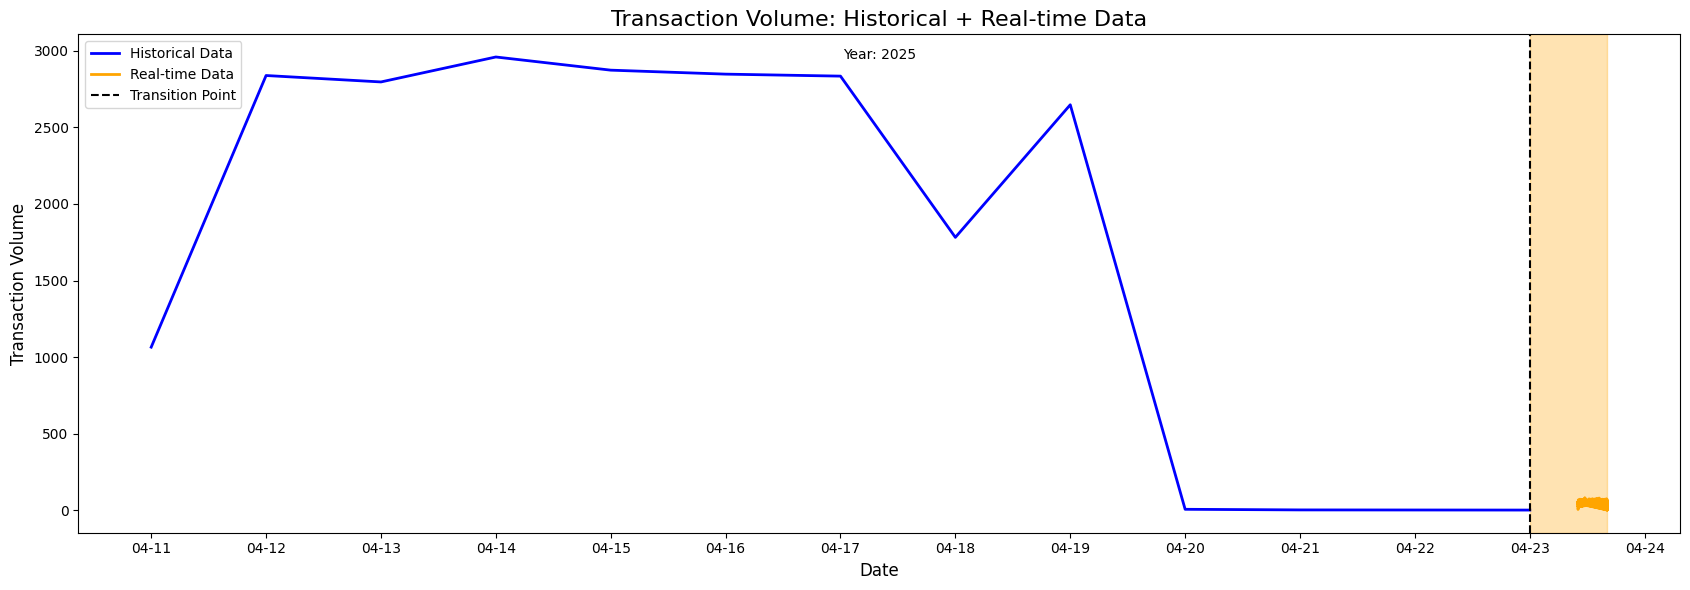

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates


dfs_realtime_dict['darooghe.streamApp.minute']['window.start'] = pd.to_datetime(dfs_realtime_dict['darooghe.streamApp.minute']['window.start'])

plt.figure(figsize=(17, 6))

# Historical trasactions
plt.plot(dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'],
         dfs_historical_dict['TransactionPatterns_daily_trend']['daily_transactions'],
         label='Historical Data', color='blue', linestyle='-', linewidth=2)

# RealTime transactions
plt.plot(dfs_realtime_dict['darooghe.streamApp.minute']['window.start'],
         dfs_realtime_dict['darooghe.streamApp.minute']['txn_count'],
         label='Real-time Data', color='orange', linestyle='-', linewidth=2)

# Add a vertical line where the real-time data starts (end of historical data)
historical_end_date = dfs_historical_dict['TransactionPatterns_daily_trend']['transaction_date'].max()
plt.axvline(historical_end_date, color='black', linestyle='--', label='Transition Point')

# Highlight
plt.axvspan(historical_end_date, dfs_realtime_dict['darooghe.streamApp.minute']['window.start'].max(), color='orange', alpha=0.3)

plt.title('Transaction Volume: Historical + Real-time Data', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Volume', fontsize=12)

# x-axis
plt.xticks(rotation=0)
plt.gca().xaxis.set_major_locator(mdates.DayLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.annotate('Year: 2025', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='black')

plt.grid(False)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


According to the graph above some event may had accured on 18-04-2025 because of the unusaul trasaction drop.

First lets find out whether its a special day in the weekend or is it something specific about the date.

18 is **Friday**, maybe we could say that on fridays people have less transactions becuase no special event orccured that date. For better correlations we need more data of transactions through the days. For now this is a hypothesis. 

In [50]:
# Aggregate the real-time data by day (sum the transactions per day)
dfs_realtime_dict['darooghe.streamApp.minute']['date'] = dfs_realtime_dict['darooghe.streamApp.minute']['window.start'].dt.date
real_time_daily = dfs_realtime_dict['darooghe.streamApp.minute'].groupby('date')['txn_count'].sum().reset_index()

print(real_time_daily.head(8))


         date  txn_count
0  2025-04-23     274778


#### Merchant Analysis: Top 5 Merchants by Number of Transactions

In this section, we will analyze the **top 5 merchants** based on the **number of transactions** recorded in the dataset. We will use a **bar chart** to visualize the comparison between merchants, with each bar representing the number of transactions for a given merchant category.

The data we are using is gatherd in the `TransactionPatterns_merchant_behavior` dataframe, which contains the needed information about each merchants transaction activity. The chart will help us identify which merchants have the highest transaction volumes, providing insights into their business activity.



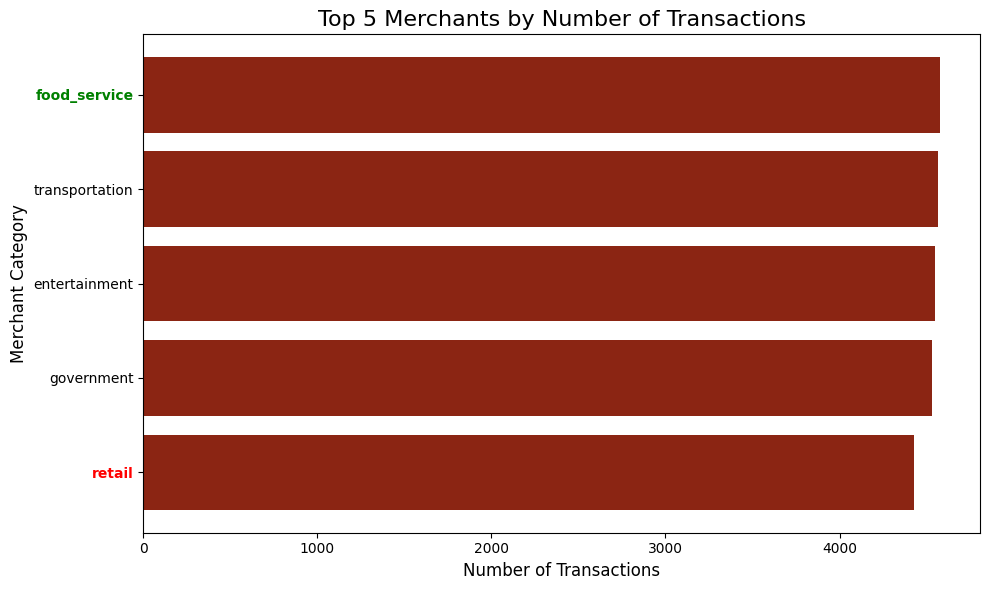

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already loaded the dataframes for historical and real-time data

# Extract the merchant behavior data
merchant_behavior_df = dfs_historical_dict['TransactionPatterns_merchant_behavior']

# Sort by transaction count in descending order and get the top 5 merchants
top_5_merchants = merchant_behavior_df[['merchant_category', 'transaction_count']].sort_values(by='transaction_count', ascending=False).head(5)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))

# Create the horizontal bar chart for the top 5 merchants
bars = plt.barh(top_5_merchants['merchant_category'], top_5_merchants['transaction_count'], color='#8B2513')  # More brown color

# Add labels and title
plt.title('Top 5 Merchants by Number of Transactions', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Merchant Category', fontsize=12)

# Invert the y-axis to display the highest transactions on top
plt.gca().invert_yaxis()

# Change color and bold the y-tick labels: green for the max and red for the min
for i, label in enumerate(plt.gca().get_yticklabels()):
    if top_5_merchants['transaction_count'].iloc[i] == top_5_merchants['transaction_count'].max():
        label.set_color('green')  # Green for max transaction count
        label.set_fontweight('bold')  # Bold the green label
    elif top_5_merchants['transaction_count'].iloc[i] == top_5_merchants['transaction_count'].min():
        label.set_color('red')  # Red for min transaction count
        label.set_fontweight('bold')  # Bold the red label

# Adjust layout for tight fit
plt.tight_layout()

# Show the plot
plt.show()


#### User Activity: Transactions and Engagement Metrics

In this section, we will analyze **user activity** based on metrics such as the **number of transactions per user**. By focusing on the **top 5 users** with the highest transaction counts, we will gain insights into user engagement and activity levels. This bar chart visualizes the users with the highest number of transactions, helping us identify the most active users within the dataset.


Now lets see the top 5 users by their activity.


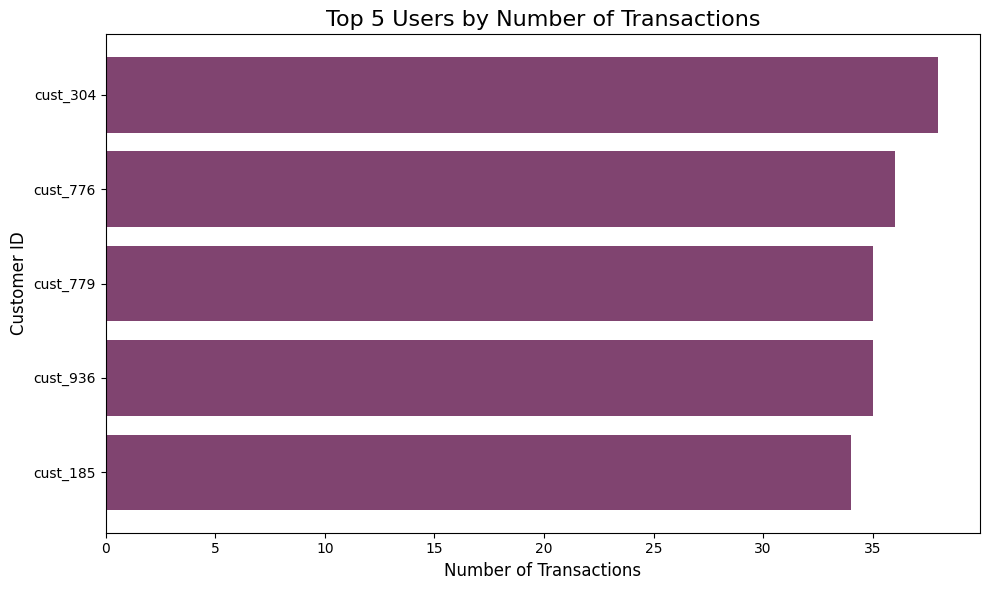

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


customer_segments_df = dfs_historical_dict['TransactionPatterns_customer_segments']
top_5_users = customer_segments_df[['customer_id', 'transaction_count']].sort_values(by='transaction_count', ascending=False).head(5)

plt.figure(figsize=(10, 6))
plt.barh(top_5_users['customer_id'], top_5_users['transaction_count'], color='#804470')  # light purple

plt.title('Top 5 Users by Number of Transactions', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Customer ID', fontsize=12)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


## Bonus Tasks

### Pipeline Optimization



We will have a complete and professional explanation of **resource monitoring** meetrics generated by <u>**ChatGPT**</u>

#### Resource Monitoring Metrics: Kafka Consumer Lag, Spark Executor CPU/MEM, and JVM Garbage Collection Time

In modern distributed systems, especially when dealing with streaming data or large-scale computations, it's essential to have effective monitoring in place. Metrics such as **Kafka Consumer Lag**, **Spark Executor CPU and Memory usage**, and **JVM Garbage Collection (GC) time** are critical to understanding the performance of your system, identifying bottlenecks, and ensuring that resources are efficiently utilized. Let's delve deeper into each of these metrics and their relevance.

---

##### 1. **Kafka Consumer Lag**:

**Definition**: 
- **Kafka Consumer Lag** refers to the difference between the latest message available in a Kafka topic and the position of the consumer group that is reading from that topic. Lag is measured in terms of the number of messages that the consumer has not yet processed.

**Why It's Important**:
- Kafka consumers are designed to process messages as they arrive. If there is a large consumer lag, it indicates that consumers are not keeping up with the rate at which messages are being produced in Kafka topics. This could result in delays in data processing, loss of real-time data handling, and in worst cases, the consumer may fall behind too much to catch up with new messages. 
- Monitoring Kafka lag helps prevent situations where consumers become overwhelmed, leading to delayed or missed data processing.

**Common Issues Indicated by High Lag**:
   - **Underpowered Consumers**: Insufficient resources for consumers to process messages fast enough.
   - **Slow Processing**: The consumer application might be taking longer than expected to process each message.
   - **Overloaded Broker**: The Kafka brokers might be overloaded, causing messages to accumulate in the topic partitions.
   - **Network Latency**: A slow or unreliable network could delay message consumption.

**Solutions**:
- **Scaling Consumers**: Adding more consumers or scaling the current consumer instances vertically (more CPU, memory) can help balance the load.
- **Optimize Consumer Logic**: If your consumer logic is slow, identifying and optimizing the bottleneck in the processing pipeline can help reduce lag.
- **Increase Kafka Partition Count**: If the lag is due to a high volume of messages, increasing the number of partitions in Kafka topics can distribute the load across more consumers.

**Prometheus Metrics for Monitoring**:
   - **`kafka_consumer_lag`**: Prometheus exporters like **Kafka Exporter** provide this metric. It tracks the lag of each consumer group, allowing you to set alerts when lag exceeds predefined thresholds.

---

##### 2. **Spark Executor CPU and Memory Usage**:

**Definition**:
- Spark executors are responsible for executing tasks and managing computation in a Spark cluster. **CPU usage** and **memory (MEM) usage** are crucial metrics that reflect the efficiency and resource utilization of these executors.
- **CPU Usage** tracks the processing power being consumed by each executor.
- **Memory Usage** tracks how much of the executor's allocated memory is being utilized.

**Why It's Important**:
- **Efficiency**: Monitoring CPU and memory usage ensures that executors are being used efficiently and that no executor is overburdened or underutilized. Inefficient resource usage can lead to wasted resources, slow performance, or even job failures if resources are exhausted.
- **Bottleneck Identification**: High CPU usage can indicate that the executor is processing more data than it can handle efficiently, leading to slowdowns or failures. High memory usage or out-of-memory errors can lead to task failures and performance degradation.

**Common Issues Indicated by High CPU or Memory Usage**:
   - **Under-allocated Resources**: Executors may be running out of memory or CPU power, causing processing delays or failures.
   - **Skewed Data Distribution**: If data isn't evenly distributed across tasks, certain executors might become overloaded while others remain underutilized.
   - **Memory Leaks**: Excessive memory usage without release can be indicative of memory leaks within the Spark job.

**Solutions**:
- **Adjust Executor Memory and CPU**: Tune Spark configurations (`spark.executor.memory`, `spark.executor.cores`) to allocate more resources to executors.
- **Optimize Data Partitioning**: Ensure data is evenly distributed across all executors to avoid one executor being overloaded.
- **Use Dynamic Allocation**: Spark's dynamic resource allocation (`spark.dynamicAllocation.enabled`) can automatically scale resources based on workload.

**Prometheus Metrics for Monitoring**:
   - **`spark_executor_cpu_time`** and **`spark_executor_memory_used`**: These metrics can be captured using the **Spark Exporter** or **JMX Exporter**, providing insights into how much CPU and memory each executor is using during execution.

---

##### 3. **JVM Garbage Collection (GC) Time**:

**Definition**:
- **JVM Garbage Collection (GC) Time** refers to the time spent by the Java Virtual Machine (JVM) cleaning up unused objects from memory. The JVM performs garbage collection to free up heap space by reclaiming memory that is no longer referenced.
- The metric typically includes **total GC time** and **pause times** (how long the JVM was paused for garbage collection).

**Why It's Important**:
- Garbage collection is a necessary process in JVM-based applications to manage memory. However, if the JVM spends too much time on GC, it can significantly slow down application performance. GC pauses, especially in a real-time or latency-sensitive system, can cause delays and noticeable lags in system response times.
- **Excessive GC time** can be a sign that your application is consuming too much memory, causing frequent GC cycles, which in turn impacts system throughput.

**Common Issues Indicated by High GC Time**:
   - **Memory Leaks**: When objects are not properly dereferenced, the JVM has to work harder to reclaim memory, leading to high GC times.
   - **Inadequate Heap Size**: If the JVM heap is too small, frequent GC cycles can occur, slowing down the application.
   - **Large Object Creation**: Large, complex objects can lead to long GC pauses as the JVM tries to clean up large chunks of memory.

**Solutions**:
- **Heap Size Tuning**: Adjust the JVM heap size using flags like `-Xms` and `-Xmx` to allocate enough memory for your application.
- **Optimize Object Creation**: Minimize unnecessary object creation and ensure proper memory management in the application.
- **GC Tuning**: Use different garbage collectors, such as G1 or CMS, that may offer better performance for specific workloads.

**Prometheus Metrics for Monitoring**:
   - **`jvm_gc_seconds_total`** and **`jvm_gc_pause_seconds_total`**: The **JVM Exporter** or **JMX Exporter** can be used to expose these metrics. Prometheus can then scrape these metrics to track the total and pause times spent on garbage collection.

---

#### General Approach to Resource Monitoring:

**1. Implementing Prometheus Metrics**:
   - **Kafka Consumer Lag**: Set up **Kafka Exporter** to expose consumer lag metrics.
   - **Spark Executor Metrics (CPU/MEM)**: Use **Spark's built-in Prometheus integration** or **Spark Exporter** to expose executor-level resource usage metrics.
   - **JVM GC Metrics**: Use the **JVM Exporter** or **JMX Exporter** to expose garbage collection metrics from your JVM applications.

**2. Setting up Prometheus**:
   - Configure Prometheus to **scrape these metrics** from the respective exporters (Kafka, Spark, and JVM).
   - Use **Prometheus queries** to monitor resource consumption over time and identify trends or issues.

**3. Visualization and Alerts**:
   - **Grafana Dashboards**: Integrate Prometheus with **Grafana** for visualizing metrics such as Kafka consumer lag, Spark executor resource usage, and JVM garbage collection time.
   - **Alerting**: Set up **Prometheus alerting** to notify you when any resource usage (e.g., consumer lag, high GC time, high CPU/memory usage) exceeds a predefined threshold.

#### Conclusion:
By implementing **Prometheus monitoring** for **Kafka consumer lag**, **Spark executor resource usage**, and **JVM garbage collection**, you gain comprehensive insights into the performance and health of your distributed system. Monitoring these metrics allows you to proactively address performance bottlenecks, ensure efficient resource usage, and maintain system stability.